<a href="https://colab.research.google.com/github/mukhairatil/ABSA_BRIMO_GooglePlaystore_IndoRoBERTa/blob/main/absa_brimo_indoroberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install google-play-scraper pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00


In [14]:
# Import Library
from google_play_scraper import reviews, Sort
import pandas as pd
from datetime import datetime

# ID Aplikasi BRImo
app_id = "id.co.bri.brimo"

# periode waktu
start_date = datetime(2025, 6, 24)
end_date   = datetime(2025, 12, 24)

all_reviews = []
continuation_token = None

# Loop untuk mengambil Semua Review Dalam Periode
while True:
    result, continuation_token = reviews(
        app_id,
        lang='id',
        country='id',
        sort=Sort.NEWEST,
        count=200,
        continuation_token=continuation_token
    )

    if not result:
        break

    for review in result:
        review_date = review['at']

        # Lewati jika lebih baru dari end_date
        if review_date > end_date:
            continue

        # Jika sudah lebih lama dari start_date, hentikan total loop
        if review_date < start_date:
            break

        all_reviews.append(review)

    # Jika data terakhir sudah melewati start_date → stop
    if result[-1]['at'] < start_date:
        break

In [15]:
#mengubah ke dataframe
df = pd.DataFrame(all_reviews)

print("Total review dalam periode:", len(df))
print("Tanggal terlama:", df['at'].min())
print("Tanggal terbaru:", df['at'].max())

Total review dalam periode: 55458
Tanggal terlama: 2025-06-24 00:00:01
Tanggal terbaru: 2025-12-23 23:58:50


In [22]:
df_5000 = df.sample(n=5000, random_state=42)

print("Jumlah data setelah sampling:", len(df_5000))

Jumlah data setelah sampling: 5000


In [19]:
df_5000.to_csv("5000ulasan_brimo_24Juni_24Desember_2025.csv",index=False, encoding='utf-8-sig')

print("File berhasil disimpan!" )

File berhasil disimpan!


In [24]:
print("Jumlah data:", len(df_5000))
df_5000.head()

Jumlah data: 5000


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
21232,6edd76c1-fdc7-4e49-b87b-3eb7fd2e0fc2,Arief,https://play-lh.googleusercontent.com/a/ACg8oc...,praktis,5,0,2.87.1,2025-09-18 13:32:50,"Hai Sobat BRI, terima kasih atas ulasannya 😊. ...",2025-09-18 13:50:54,2.87.1
33208,c14edc03-8ee6-45a4-806b-9e349eac4b71,Sumilah 123,https://play-lh.googleusercontent.com/a/ACg8oc...,bagus,5,0,2.87.1,2025-08-19 11:03:25,"Hai Sobat BRI, terima kasih atas ulasannya 😊. ...",2025-08-19 11:36:42,2.87.1
33179,a862fa80-09d7-4670-9ebc-09a3eef2ff5a,Bunda Atthar,https://play-lh.googleusercontent.com/a/ACg8oc...,Semoga selalu di utamakan kenyamanan nya,5,0,2.87.1,2025-08-19 12:52:47,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-08-19 13:08:27,2.87.1
4800,d1360668-fcd6-410f-a124-63dfe0f78406,Rizqi S,https://play-lh.googleusercontent.com/a-/ALV-U...,tolong lah tolong inimah jangan malah batasi s...,1,2,2.90.0,2025-12-01 13:46:43,"Hai Sobat BRI, mohon maaf atas kendala yang di...",2025-12-01 18:34:57,2.90.0
50058,e830f20a-edc5-469c-9670-91b767e011e5,Maria Halungmo,https://play-lh.googleusercontent.com/a/ACg8oc...,Sangat membantu sekali,5,0,2.85.0,2025-07-03 12:42:32,"Hai Sobat BRI, terima kasih atas ulasannya. Se...",2025-07-03 12:54:17,2.85.0


In [25]:
df['score'].value_counts().sort_index()

,count
score,
1,7053
2,1490
3,1654
4,3175
5,42086


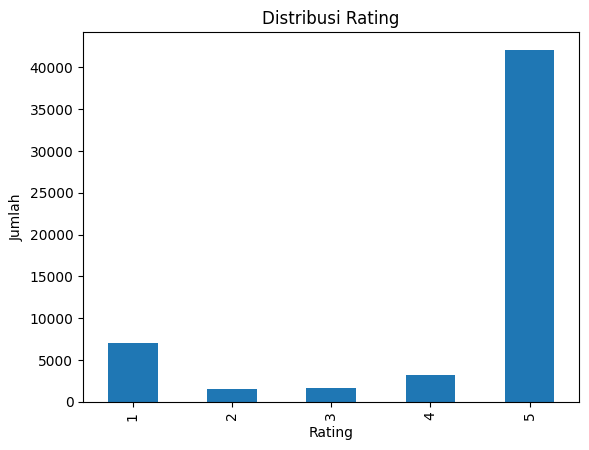

In [26]:
import matplotlib.pyplot as plt

df['score'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

In [27]:
def label_sentiment(score):
    if score <= 2:
        return "negatif"
    elif score == 3:
        return "netral"
    else:
        return "positif"

df['sentiment'] = df['score'].apply(label_sentiment)

df['sentiment'].value_counts()

,count
sentiment,
positif,45261
negatif,8543
netral,1654


In [28]:
df['clean_text'] = df['content'].str.lower()

In [31]:
#menghapus url,angka,simbol dan missing value
import re

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['clean_text'] = df['clean_text'].apply(clean_text)
df = df.dropna(subset=['clean_text'])

In [34]:
#mengidentifikasi aspek menggunakan aspect category classification.
aspects = {
    "login" : ["login","masuk","otp"],
    "performa": ["error","lambat","bug","gagal","loading"],
    "fitur": ["transfer","top up","qris","transaksi"],
    "keamanan": ["aman","otp","verifikasi","password"],
    "kemudahan": ["mudah","ribet","sulit","user friendly"],
    "layanan": ["cs","customer service","respon"]
}

def detect_aspect(text):
    for aspect, keywords in aspects.items():
        for keyword in keywords:
            if keyword in text:
                return aspect
    return "lainnya"

df['aspect'] = df['clean_text'].apply(detect_aspect)

df['aspect'].value_counts()

,count
aspect,
lainnya,37406
fitur,5948
kemudahan,5852
login,2711
keamanan,1943
performa,1324
layanan,274
